In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-data/train.csv
/kaggle/input/titanic-data/test.csv
/kaggle/input/titanic-data/gender_submission.csv


In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_19/2889067548.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# refactor the data

In [3]:
ABStest_data = pd.read_csv("/kaggle/input/titanic-data/test.csv")
train_data = pd.read_csv("/kaggle/input/titanic-data/train.csv")

columns_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]

train_data.drop(columns_to_drop, axis=1, inplace=True)
ABStest_data.drop(columns_to_drop, axis=1, inplace=True)

train_data["Sex"] = train_data["Sex"].replace({"male":0, "female":1})
train_data["Embarked"] = train_data["Embarked"].replace({"S":0, "C":1, "Q":2})

ABStest_data["Sex"] = ABStest_data["Sex"].replace({"male":0, "female":1})
ABStest_data["Embarked"] = ABStest_data["Embarked"].replace({"S":0, "C":1, "Q":2})

train_data.dropna(inplace=True)
ABStest_data.dropna(inplace=True)

train_labels = train_data["Survived"]
train_data.drop("Survived", axis=1, inplace=True)

train_data


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,0.0
1,1,1,38.0,1,0,71.2833,1.0
2,3,1,26.0,0,0,7.9250,0.0
3,1,1,35.0,1,0,53.1000,0.0
4,3,0,35.0,0,0,8.0500,0.0
...,...,...,...,...,...,...,...
885,3,1,39.0,0,5,29.1250,2.0
886,2,0,27.0,0,0,13.0000,0.0
887,1,1,19.0,0,0,30.0000,0.0
889,1,0,26.0,0,0,30.0000,1.0


# Normalize the data

In [4]:
train_dataNorm = train_data
ABStest_dataNorm = ABStest_data

#normalize for each columns own max values instead of doing as below of all columns max value
#ONLY WORKS IF RUN ALL BECAUSE OF VARIABLE REUSE BELOW!!! (train_data)
cols = train_data.select_dtypes(include=['number'])
train_dataNorm = cols/cols.max()

#train_dataNorm = train_data/np.max(train_data)
#ABStest_dataNorm = ABStest_data/np.max(ABStest_data)

train_dataNorm

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.000000,0.0,0.2750,0.2,0.000000,0.014151,0.0
1,0.333333,1.0,0.4750,0.2,0.000000,0.139136,0.5
2,1.000000,1.0,0.3250,0.0,0.000000,0.015469,0.0
3,0.333333,1.0,0.4375,0.2,0.000000,0.103644,0.0
4,1.000000,0.0,0.4375,0.0,0.000000,0.015713,0.0
...,...,...,...,...,...,...,...
885,1.000000,1.0,0.4875,0.0,0.833333,0.056848,1.0
886,0.666667,0.0,0.3375,0.0,0.000000,0.025374,0.0
887,0.333333,1.0,0.2375,0.0,0.000000,0.058556,0.0
889,0.333333,0.0,0.3250,0.0,0.000000,0.058556,0.5


# Convert to pytorch tensors

In [5]:
train_dataNorm_np = train_dataNorm.to_numpy()
dataT = torch.tensor(train_dataNorm_np)

train_labels_np = train_labels.to_numpy()
labelsT = torch.tensor(train_labels_np)

ABStest_dataNorm_np = ABStest_dataNorm.to_numpy()
ABStest_dataNorm_tensor = torch.tensor(ABStest_dataNorm_np)

#ABStest_labels_np = ABStest_labels.to_numpy()
#ABStest_labels_tensor = torch.tensor(ABStest_labels_np)

In [6]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

In [7]:
train_data.tensors[0].shape

torch.Size([640, 7])

# Make to DataLoaders

In [8]:
batchsize = 8
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [9]:
def createTheModel():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            ###layers
            self.input = nn.Linear(7, 64)
            self.hidden = nn.Linear(64,64)
            self.output = nn.Linear(64,1)
            
        def forward(self,x):
            x = F.relu( self.input(x) )
            x = F.relu( self.hidden(x) )
            x = self.output(x)
            return x
        
    #model instance
    net = mnistNet()
    
    #lossfun
    lossfun = nn.BCEWithLogitsLoss()
    
    #optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=0.0001)
    
    return net,lossfun,optimizer

In [10]:
net,lossfun,optimizer = createTheModel()

# Create a function that trains the model

In [11]:
def function2trainTheModel():
    
    numepochs = 100
    
    #create a new model
    net,lossfun,optimizer = createTheModel()
    
    #initizalize the losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    
    #loop over epochs
    for epochi in range(numepochs):
        
        #loop over training data batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            #forward pass and loss
            #print(X.dtype)
            X = X.to(torch.float32)
            y = y.to(torch.float32)
            #yHat = torch.sigmoid(net(X).squeeze())
            yHat = net(X).squeeze()
            #print(yHat)
            
            loss = lossfun(yHat,y)
            #print(loss)
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #loss from ths batch
            batchLoss.append(loss.item())
            
            #compute accuracy
            #predictions = yHat > 0.5
            #matches = predictions == y
            #accuracyPct = 100*torch.mean(matches.float())
            #batchAcc.append( accuracyPct )
            
            batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
            
        #end of batch loop...
        
        #get average batch training accuracy
        trainAcc.append( np.mean(batchAcc) )
        
        #and average losses across the batches
        losses[epochi] = np.mean(batchLoss)
        
        #test accuracy
        with torch.no_grad(): #deactivates autograd
            X,y = next(iter(test_loader))
            X = X.to(torch.float32)
            y = y.to(torch.float32)
            #yHat = torch.sigmoid(net(X).squeeze())
            yHat = net(X).squeeze()
            
            #predictions = yHat > 0.5
            #matches = predictions == y
            #testAcc.append(100*torch.mean(matches.float()))
            
            testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
            
        #testAcc.append(  )
        
    #end epochs
    
    return trainAcc,testAcc,losses,net

# Run the model and pray

In [12]:
trainAcc,testAcc,losses,net = function2trainTheModel()

# Plot the results

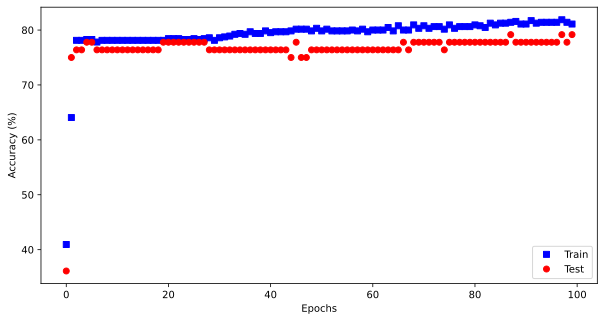

In [13]:
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs')
plt.plot(testAcc,'ro')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

plt.show()